# Sunphotometer Analysis from the 19th May

In [1]:
from __future__ import division
%matplotlib inline
import cPickle
import datetime
from dateutil import parser
import itertools
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import numpy as np
import os
import pandas as pd
from scipy.integrate import quadrature, romberg, quad, fixed_quad
from scipy.interpolate import interp1d
from scipy.special import legendre
from tqdm import tqdm_notebook

from IPython.display import Image
from IPython.core.display import HTML 

## Set the Target Time/Date And Wavelength

In [2]:
Image(url= "https://aeronet.gsfc.nasa.gov/cgi-bin/draw_new_oleg_v2?site=Technion_Haifa_IL&year=25&month=4&day=18&product=7&level=2&type=0&if_day=0&if_err=0&inv=1")

In [3]:
TIME = pd.datetime(2017, 5, 19, 12, 35, 0)
WAVELENGTH = 670

# Load the sunphotometer data

## Load the phasefunction

The data is loaded from the sunphotometer logs. Note that new values are interpolated for TIME and WAVELENGTH. I use the "pchip" interpolation method as it is more conservative.

In [4]:
def dateparse(d, t):
    return pd.datetime.strptime(d+' '+t, '%d:%m:%Y %H:%M:%S')

def parsePhaseFunction(path, usecols):
    """Parse the sunphotometer Phase Function data."""

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=usecols
    )

    wavelengths = [float(i.split("[")[0]) for i in df.columns]
    df = df.rename(columns=dict(itertools.izip(df.columns, wavelengths)))
    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df, wavelengths

pfn_path = r"../../data/aeronet/2017_05/170519_170519_Technion_Haifa_IL.pfn"
df_441, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(3, 86))
)
df_674, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(86, 169))
)
df_871, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(169, 252))
)
df_1020, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(252, 335))
)

In [5]:
series = [pd.Series(d.loc[TIME], name=n) for d, n in zip((df_441, df_674, df_871, df_1020), (441., 674., 871., 1020.))]
df_phf = pd.concat(series, axis=1).T
new_row = pd.Series(name=WAVELENGTH, data=[None]*len(df_phf.columns), index=df_phf.columns)
df_phf = df_phf.append(new_row).sort_index().interpolate(method="pchip")

In [6]:
df_phf.head()

,0.0,1.71,3.93,6.16,8.39,10.63,12.86,15.1,17.33,19.57,...,160.43,162.67,164.9,167.14,169.37,171.61,173.84,176.07,178.29,180.0
441.0,339.824069,139.801186,48.916872,24.326606,15.001301,10.619730,8.235330,6.740440,5.719047,4.954567,...,0.142630,0.145330,0.148720,0.153110,0.159010,0.166880,0.177590,0.190960,0.201140,0.20431
670.0,206.811689,123.791589,54.790626,29.278102,18.188217,12.501833,9.253057,7.202291,5.836833,4.864310,...,0.174426,0.177016,0.180616,0.185931,0.193853,0.205097,0.220372,0.238313,0.251045,0.25468
674.0,205.229311,123.460721,54.792959,29.323766,18.229200,12.531160,9.271850,7.212720,5.840330,4.864310,...,0.174440,0.177030,0.180640,0.185990,0.193960,0.205260,0.220580,0.238530,0.251240,0.25486
871.0,146.050559,103.745197,53.831030,30.842166,19.830784,13.838570,10.250940,7.921090,6.332408,5.194203,...,0.174260,0.176890,0.180920,0.187200,0.196560,0.209550,0.226250,0.244360,0.256260,0.25939
1020.0,115.542406,89.131086,51.059776,30.766165,20.354427,14.465980,10.836390,8.431651,6.751410,5.527181,...,0.168220,0.170800,0.174950,0.181590,0.191530,0.205190,0.222380,0.240410,0.251890,0.25486


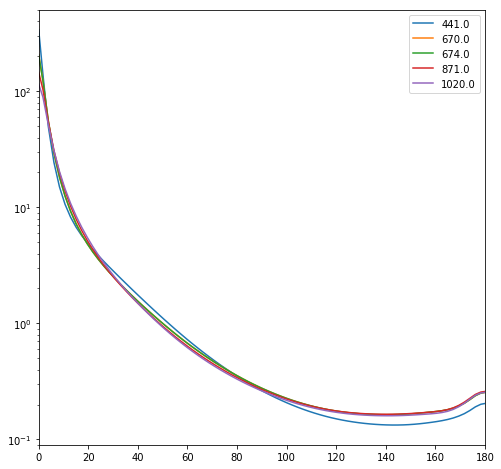

In [7]:
df_phf.T.plot(logy=True)

## Load the Single-Scatter Albedo

In [8]:
def parseSSA(path):
    """Parse the sunphotometer SSA data."""

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=[0, 1]+list(range(3, 7))
    )

    wavelengths = [float(i[3:-2]) for i in df.columns]
    df = df.rename(columns=dict(itertools.izip(df.columns, wavelengths)))
    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df

ssa_path = r"../../data/aeronet/2017_05/170519_170519_Technion_Haifa_IL.ssa"

df_ssa = parseSSA(ssa_path)

### Interpolate by wavelength

In [9]:
new_row = pd.Series(name=WAVELENGTH, data=[None]*len(df_ssa.T.columns), index=df_ssa.T.columns)

df_ssa = df_ssa.T.append(new_row).sort_index().interpolate(method="pchip")

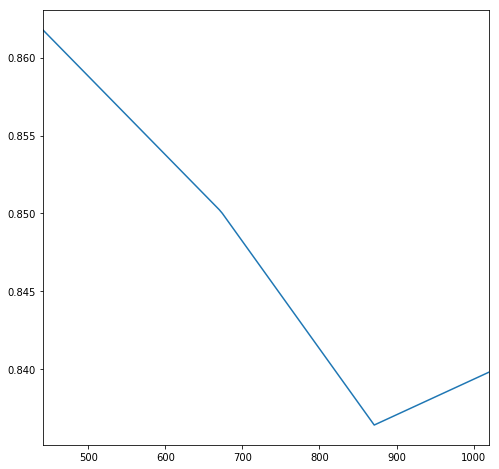

In [10]:
df_ssa.T.loc[TIME].T.plot()

In [11]:
df_ssa.loc[WAVELENGTH][TIME]

0.850234316002769

## Load the AOD

In [12]:
def parseAOD(path):
    """Parse the sunphotometer AOD data."""

    df = pd.read_csv(
        path,
        skiprows=4,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=[0, 1]+list(range(3, 14))
    )

    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df

aod_path = r"../../data/aeronet/2017_05/170519_170519_Technion_Haifa_IL.lev15"

df_aod = parseAOD(aod_path)

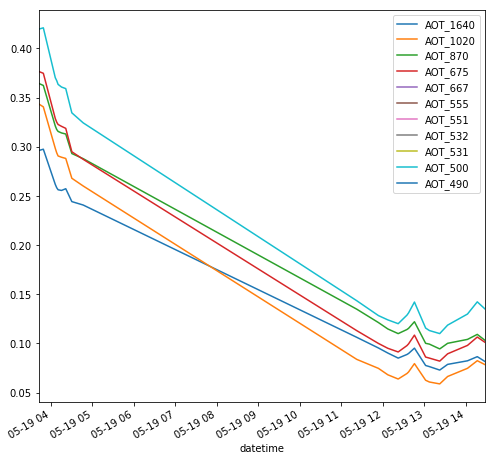

In [13]:
df_aod.plot()

In [14]:
df_aod.AOT_675[TIME]

0.097889875988507305

# Calculate the Legndre Coefficients

The (intensity) phase function is conventionally normalized as follows

$$\int_0^{2\pi} \int_0^\pi P(\Theta) \sin(\Theta) d\Theta d\phi = 4 \pi$$

Which is equivalent to

$$\int_{-1}^1 P(\cos{\Theta}) d(\cos{\Theta}) = 2$$

Integrating the phase function from the sunphotometer gives:

# Calculate the Legendre Coefficients

## Use quadrature integration

Note I am using linear interpolation. The reason is that higher order interpolation creates artifacts, probably due to the high directionality of the phase function.

In [15]:
COFFES_NUM = 300

In [16]:
mu = np.cos(np.radians(wavelengths[::-1]))
phase = df_phf.loc[WAVELENGTH].values[::-1]

phase_interp = interp1d(mu, phase, kind=1)

def func(x, l, lg):
    return (2*l + 1)/2. * lg(x)*phase_interp(x)

In [17]:
coeffs_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    lg = legendre(l)
    #coeffs_quad.append(quad(func, -1, 1, args=(l, lg,), limit=1000)[0])
    #coeffs_quad.append(fixed_quad(func, -1, 1, args=(l, lg,), n=50000)[0])
    coeffs_quad.append(quadrature(func, -1, 1, args=(l, lg,), maxiter=1000)[0])

A Jupyter Widget

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.346377e-06
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.003141e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.664317e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.919536e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.518868e-05
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.761422e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.010101e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.107946e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.181619e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.214090e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.625910e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.869362e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.071318e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.242445e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.375277e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.487201e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.487035e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.473339e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.442767e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.400734e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.913119e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.000737e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.042623e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.032165e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.980036e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.939280e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.774415e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.623618e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.510405e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.395758e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.449848e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.475837e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.453917e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.383571e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.236757e-04
  AccuracyWarning)
/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: Accuracy

/home/amitibo/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.646693e-04
  AccuracyWarning)


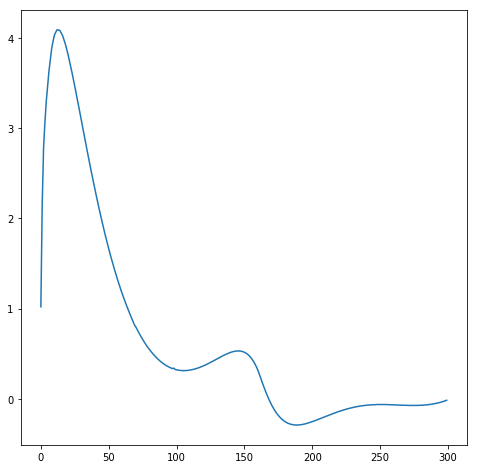

In [18]:
plt.plot(coeffs_quad)

## Reconstruct the Phase function by the Legndre coefficients

In [19]:
mu_new = np.linspace(-1, 1, 3000)
phase_gauss = 0
for l, coeff in enumerate(coeffs_quad):
    phase_gauss += legendre(l)(mu_new) * coeff
coeffs_quad_ = coeffs_quad[:]
coeffs_quad_[0] = 1.
phase_gauss_ = 0
for l, coeff in enumerate(coeffs_quad_):
    phase_gauss_ += legendre(l)(mu_new) * coeff

(0.95, 1)

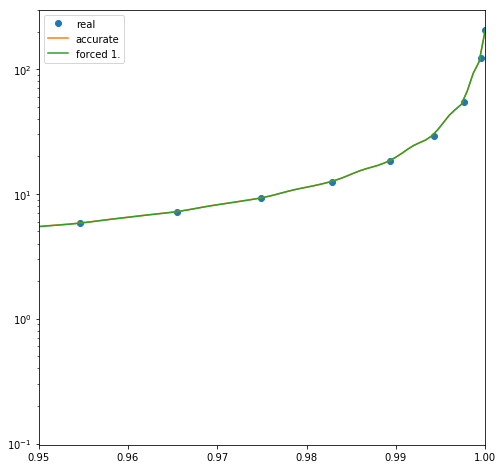

In [32]:
plt.semilogy(mu, phase, "o", label="real")
plt.semilogy(mu_new, phase_gauss, "-", label="accurate")
plt.semilogy(mu_new, phase_gauss_, label="forced 1.")
plt.legend()
plt.xlim(0.95, 1)

### Save the result as pickle

In [33]:
import pickle

In [36]:
with open("particles_2017_05_19.pkl", "wb") as f:
    pickle.dump(
        dict(
            ssa=df_ssa.loc[WAVELENGTH][TIME],
            legend=coeffs_quad_,
            aod=df_aod.AOT_675[TIME],
            aod_height=2.5
        ),
        f
    )

### Save the result

In [58]:
header = """! Mie scattering table vs. effective radius (LWC=1 g/m^3)
  0.{}    0.{}    0.000  wavelength range and averaging step (micron)
   2    1.450    1.450  number       starting       ending REAL refractive index
   2    0.000    0.000  number       starting       ending IMAGINARY refractive index
   2    0.100    0.100  number       starting       ending effective radius
   2    0.500    0.500  number       starting       ending effective variance
 """.format(WAVELENGTH, WAVELENGTH)
line_template = " 1.450 -.000     1.000    %f   0.5000   0.1000     %d  Phase function: Re{m}  Im{m}   Ext  Alb  Veff  Reff  Nleg\n"

In [59]:
with open(TIME.strftime("aerosol{}dredvedm__%Y%m%d_%H%M.scat".format(WAVELENGTH)), "w") as f:
    f.write(header)
    for i in range(700):
        f.write(line_template % (df_ssa.loc[WAVELENGTH][TIME], len(coeffs_quad_)-1))
        f.write("\t".join(['']+[str(c) for c in coeffs_quad_]))
        f.write("\n")